# Equations of State

## Setup

In [1]:
from matplotlib import colors, cm, colormaps as cmaps, pyplot as plt
import numpy as np

from carpy.physicalchem import species, UnreactiveFluidModel
from carpy.physicalchem import (
    IdealGas, VanderWaals as VdW, RedlichKwong as RK, SoaveRedlichKwong as SRK,
    SRKmodPeneloux as SRKmP, PengRobinson as PR, HydrogenGas as HG
)
from carpy.utility import Quantity

In [2]:
# For looping, we'll define an iterable for the equations of state to test
equations_of_state = (IdealGas, VdW, RK, SRK, SRKmP, PR, HG)

In [3]:
# For temperature colouration, use a colour map where the normalised temperature is white
cmap = plt.get_cmap("coolwarm")

def get_colour(x):
    """Get (R, G, B, A) scaled with reduced temperature array, such that T_r=1.0 corresponds to white."""
    y = np.interp(x, (T_rs.min(), 1.0, T_rs.max()), (0, 0.5, 1.0))
    c = cmap(y)
    return c

## Hydrogen

### Phase Diagrams

In [4]:
# Create test data
resolution = 25
pure_fluid = species.hydrogen()
# Pressure and temperature limits are autoscaled w.r.t critical pressure and temperature
p = Quantity(np.logspace(0, np.round(np.log10(float(pure_fluid.p_c))), resolution), "Pa")
T = Quantity(np.linspace(1e-3, 1.1 * float(pure_fluid.T_c), resolution), "K")
pgrid, Tgrid = np.meshgrid(p, T)

# Compute colourmap data
dens_data = {}
dens_poi = {}
for i, EOS in enumerate(equations_of_state):
    print(f"\r({i+1}/{len(equations_of_state)}) {EOS.__name__:<20s}", end="")

    # Instantiate a model with the given equation of state
    model = UnreactiveFluidModel(eos_class=EOS)
    model.X = {pure_fluid: 1.0}

    # Compute density data
    dens_data[EOS] = model.density(p=pgrid, T=Tgrid)
    
    adjust = 1.0
    while model.EOS.is_vapour(p=Quantity(1, "atm"), T=pure_fluid.T_boil * adjust):
        adjust *= 0.99
        if adjust < 0.9:
            adjust = 1
            break
    dens_poi[EOS] = model.density(p=Quantity(1, "atm"), T=pure_fluid.T_boil * adjust)

else:
    print(f"\n{'Finished computing':<20s}")

(7/7) HydrogenGas         
Finished computing  


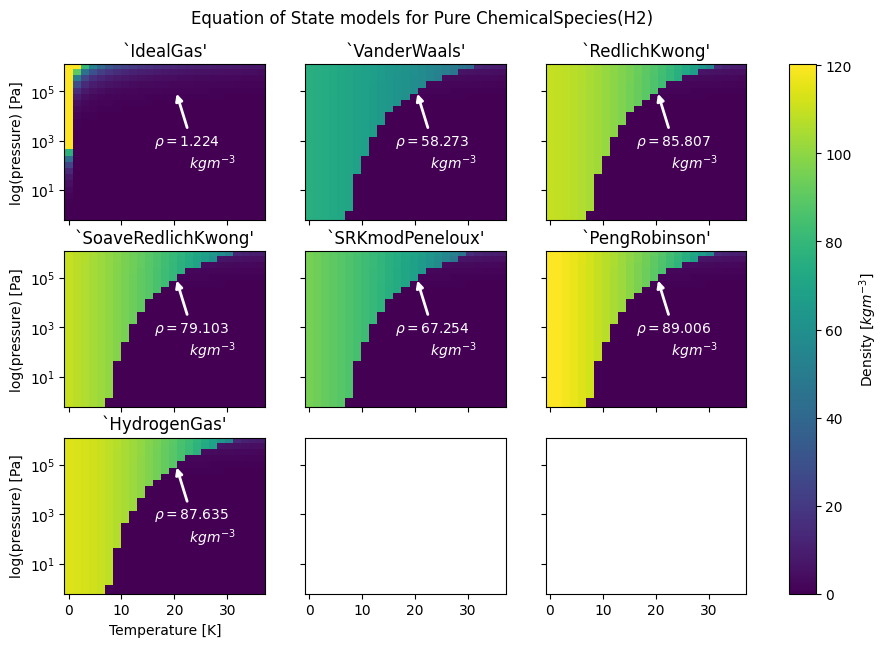

In [21]:
# Figure parameters
figwidth = 11
ncols = 3
aspect = 1.6
dens_lo = 0
dens_hi = max([np.percentile(v, 95) for (_, v) in dens_data.items()])

# Create figure
nrows = int(np.ceil(len(equations_of_state) / ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True)
fig.set_figwidth(figwidth)
fig.set_figheight((figwidth / aspect) * (nrows / ncols))
fig.suptitle(f"Equation of State models for Pure {pure_fluid}", x=0.45, y=0.96)

# Prepare figure-wide colour map
normaliser = colors.Normalize(dens_lo, dens_hi)
cmap = plt.get_cmap("viridis")

# Compute colourmap data
for i, EOS in enumerate(equations_of_state):

    ax = axs.flat[i]
    ax.set_title(f"`{EOS.__name__}'")
    ax.set_yscale("log")
    ax.set_xlabel(f"Temperature [{T.u}]")
    ax.set_ylabel(f"log(pressure) [{p.u}]")
    ax.label_outer()
    
    # Plot computed data
    ax.pcolormesh(Tgrid, pgrid, dens_data[EOS], norm=normaliser)
    ax.annotate(
        text=f"$\\rho=${float(dens_poi[EOS]):.3f}\n\t${dens_poi[EOS].u}$",
        xy=(species.hydrogen().T_boil, Quantity(1, "atm")),
        xytext=((species.hydrogen().T_boil * 0.8, Quantity(1, "atm") / 50)),
        va="top",
        arrowprops={"arrowstyle": "-|>", "color": "white", "lw": 2},
        c="white"
    )
    
im = cm.ScalarMappable(norm=normaliser, cmap=cmap)
cbar = fig.colorbar(im, ax=list(axs.flatten()))
cbar.set_label(f"Density [${dens_data[EOS].u}$]")
plt.show()